In [1]:
#%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.ticker import FormatStrFormatter
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import texttable
import gc
import timeit
import sys
import os

# Loading reported and synthetic data

In [3]:
# Revoking stored reported data
# https://ipython.org/ipython-doc/rel-0.12/config/extensions/storemagic.html

%store -r data_Averoy
%store -r data_Tingvoll
%store -r data_Surnadal
%store -r data_Sunndal
%store -r data_Vestnes
%store -r data_Laerdal

In [4]:
# Revoking top hits frames created by the spring census estimator
save_dir = "synthetic_data/"
top_hits_norm_Tingvoll_spring_census = pd.read_pickle(
    save_dir + "top_hits_norm_Tingvoll_spring_census.pkl"
)

top_hits_norm_Surnadal_spring_census = pd.read_pickle(
    save_dir + "top_hits_norm_Surnadal_spring_census.pkl"
)

top_hits_norm_Sunndal_spring_census = pd.read_pickle(
    save_dir + "top_hits_norm_Sunndal_spring_census.pkl"
)

top_hits_norm_Vestnes_spring_census = pd.read_pickle(
    save_dir + "top_hits_norm_Vestnes_spring_census.pkl"
)

top_hits_norm_Laerdal_spring_census = pd.read_pickle(
    save_dir + "top_hits_norm_Laerdal_spring_census.pkl"
)

In [5]:
# Data needed for plotting the figures below
compare = "before_hunt"
municipalities = ["Averoy", "Tingvoll", "Surnadal", "Sunndal", "Vestnes", "Laerdal"]
data_municipality = [
    data_Averoy,
    data_Tingvoll,
    data_Surnadal,
    data_Sunndal,
    data_Vestnes,
    data_Laerdal,
]

top_hits_norm_spring_census = [
    top_hits_norm_Tingvoll_spring_census,
    top_hits_norm_Surnadal_spring_census,
    top_hits_norm_Sunndal_spring_census,
    top_hits_norm_Vestnes_spring_census,
    top_hits_norm_Laerdal_spring_census,
]

afont = {"fontname": "Arial"}

# Figure 6

## Fig. 6, left panels:  Boxplots of the variation in key population parameters for the # top hits

In [6]:
def plot_parameters_spring_census(
    municipalities, data_municipality, top_hits_spring_census, ax
):
    for location in municipalities:
        if location == "Tingvoll":
            q = 0
        if location == "Surnadal":
            q = 1
        if location == "Sunndal":
            q = 2
        if location == "Vestnes":
            q = 3
        if location == "Laerdal":
            q = 4

        [
            municipality,
            first_year,
            last_year,
            number_of_years,
            years,
            seen_deer_obs,
            seen_deer_obs_outfield,
            seen_deer_obs_infield,
            hinds_per_stag_obs,
            total_harvest,
            fraction_female_calves_harvested,
            fraction_young_hinds_harvested,
            fraction_adult_hinds_harvested,
            fraction_male_calves_harvested,
            fraction_young_stags_harvested,
            fraction_adult_stags_harvested,
            spring_counts,
        ] = data_municipality[q]

        data_collected = [
            top_hits_spring_census[q]["init_hps"].values,
            top_hits_spring_census[q]["hps_ah"].values,
            top_hits_spring_census[q]["sh_threshold"].values,
            top_hits_spring_census[q]["init_pop"].values / 1000,
            top_hits_spring_census[q]["tot_pop_ah"].values / 1000,
        ]

        x_pos = [1, 2, 3, 4, 5]
        width = [0.5, 0.5, 0.5, 0.5, 0.5]
        ax[q].set_xticks(x_pos)

        from matplotlib.ticker import FormatStrFormatter

        ax[q].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

        if q == 4:
            labels = [
                "hinds_per_stag_2006",
                "hinds_per_stag_2021",
                "s_per_hind_threshold",
                "tot_pop_2006/1000",
                "tot_pop_2021/1000",
            ]
            ax[q].set_xticklabels(labels, rotation="vertical", fontsize=8)
        else:
            labels = ["", "", "", "", ""]

        ax[q].yaxis.set_major_locator(ticker.AutoLocator())
        ax[q].yaxis.set_minor_locator(ticker.AutoMinorLocator())

        ax[q].set_ylabel(municipality, fontsize=12, **afont)

        box = ax[q].boxplot(
            data_collected, showfliers=False, labels=labels, patch_artist=True
        )

        colors = ["steelblue", "firebrick", "darkslategray", "steelblue", "firebrick"]

        for patch, color in zip(box["boxes"], colors):
            patch.set_facecolor(color)

        ax[q].margins(x=0.0)
        if (q == 0) | (q == 2):
            ymin = 0
            ymax = 8
        else:
            ymin = 0
            ymax = 3
        ax[q].set_ylim([ymin, ymax])
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

## Fig. 6, right panels: Mean migration percentage in the period 2007-2020 for the top # hits

In [7]:
def migration_top_hits(top_hits_spring_census, municipality, number_of_years):
    """
    Calculating the mean for each year for the # top_hits againts
    seen deer per hour. Loading of sorted original dataframe is done
    here in case one runs a high number of replicates and gets into
    memory trouble. Then one can delete the frame here and one avoids
    having all frames open as when they are called from a list.
    """

    # Read original data frames from disk
    save_dir = "synthetic_data/"
    df_municipality = pd.read_pickle(save_dir + municipality)

    # Get all number_of_years records associated with the 9 first parameters in
    # the sorted original frame
    migration_percentage_list = []
    for k in range(len(top_hits_spring_census)):
        parameter = top_hits_spring_census.iloc[k, 0:9]
        df_hits = df_municipality.loc[
            (df_municipality["init_pop"] == parameter[0])
            & (df_municipality["init_hps"] == parameter[1])
            & (df_municipality["sh_threshold"] == parameter[2])
            & (df_municipality["i_fcalves"] == parameter[3])
            & (df_municipality["i_yhinds"] == parameter[4])
            & (df_municipality["i_ahinds"] == parameter[5])
            & (df_municipality["i_mcalves"] == parameter[6])
            & (df_municipality["i_ystags"] == parameter[7])
            & (df_municipality["i_astags"] == parameter[8])
        ].copy()

        # Extract predicted mig% array associated with the given top hit
        # and append to list
        migration_percentage_p = df_hits.iloc[0:number_of_years]["mig%"].values
        migration_percentage_list.append(list(migration_percentage_p))

    migration_percentage_array = np.array(migration_percentage_list)
    return migration_percentage_array

In [8]:
def plot_emigration_spring_census(
    municipalities, data_municipality, top_hits_spring_census, ax
):
    """
    Plots mean emigration percentage for each year over all # top_hits against
    seen deer per hour.
    """

    for location in municipalities:
        if location == "Tingvoll":
            q = 0
        if location == "Surnadal":
            q = 1
        if location == "Sunndal":
            q = 2
        if location == "Vestnes":
            q = 3
        if location == "Laerdal":
            q = 4

        [
            municipality,
            first_year,
            last_year,
            number_of_years,
            years,
            seen_deer_obs,
            seen_deer_obs_outfield,
            seen_deer_obs_infield,
            hinds_per_stag_obs,
            total_harvest,
            fraction_female_calves_harvested,
            fraction_young_hinds_harvested,
            fraction_adult_hinds_harvested,
            fraction_male_calves_harvested,
            fraction_young_stags_harvested,
            fraction_adult_stags_harvested,
            spring_counts,
        ] = data_municipality[q]

        df_original = [
            "df_original_sorted_Tingvoll.pkl",
            "df_original_sorted_Surnadal.pkl",
            "df_original_sorted_Sunndal.pkl",
            "df_original_sorted_Vestnes.pkl",
            "df_original_sorted_Laerdal.pkl",
        ]

        # Calculating the mean for each year for the # of tophits
        migration_percentage_array = migration_top_hits(
            top_hits_spring_census[q], df_original[q], number_of_years
        )

        # Make boxplot
        # Define positions as an array within call to align with the xtick-labeling below
        ax[q].boxplot(
            migration_percentage_array, positions=np.arange(15), showfliers=False
        )

        formatter = ticker.FormatStrFormatter("%.1f")
        ax[q].yaxis.set_major_formatter(formatter)
        year_list = np.arange(number_of_years)
        no_text = [""] * number_of_years

        if q < 4:
            ax[q].set_xticks(year_list)
            ax[q].set_xticklabels(no_text)
        else:
            ax[q].set_xticks(year_list)
            ax[q].set_xticklabels(years, rotation="vertical")

        # ax[q].set_ylabel("%_emigration" + "_" + municipality, fontsize=12, **afont)
        ax[q].set_ylabel(municipality + " (s_emig_%)", fontsize=12, **afont)
        ymin = 0
        ymax = 40
        ax[q].set_ylim([ymin, ymax])

    fig.tight_layout()
    fig.subplots_adjust(top=0.96)

## Plotting and saving Fig. 6

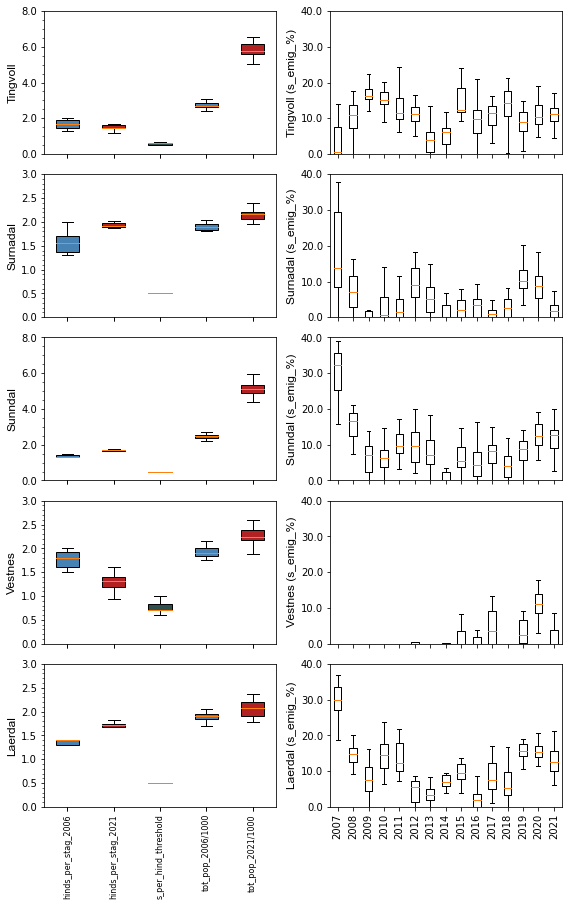

In [9]:
municipalities = ["Tingvoll", "Surnadal", "Sunndal", "Vestnes", "Laerdal"]
data_municipality = [
    data_Tingvoll,
    data_Surnadal,
    data_Sunndal,
    data_Vestnes,
    data_Laerdal,
]

fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(8, 13))
ax1 = [axs[0, 0], axs[1, 0], axs[2, 0], axs[3, 0], axs[4, 0]]
ax2 = [axs[0, 1], axs[1, 1], axs[2, 1], axs[3, 1], axs[4, 1]]

plot_parameters_spring_census(
    municipalities, data_municipality, top_hits_norm_spring_census, ax1
)
plot_emigration_spring_census(
    municipalities, data_municipality, top_hits_norm_spring_census, ax2
)

save_dir = "figures/"
plt.savefig(save_dir + "Figure_6.pdf", dpi=600, bbox_inches="tight")